In [1]:
import os
import cv2 
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.cluster import KMeans
from skimage.morphology import erosion, opening, closing, square, \
                               disk, convex_hull_image
from skimage.measure import label, regionprops

from skimage.filters import sobel
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.segmentation import watershed
    
SMALL_FONT = 13
MEDIUM_FONT = 15
LARGE_FONT = 18

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_FONT)   # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT)   # fontsize of the figure title

plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
def readSortedSlices(path):
    
    slices = []
    for s in os.listdir(path):
        slices.append(path + '/' + s)       
    slices.sort(key = lambda s: int(s[s.find('_') + 1 : s.find('.')]))
    ID = slices[0][slices[0].find('/') + 1 : slices[0].find('_')]
    print('CT scan of Patient %s consists of %d slices.' % (ID, len(slices)))  
    return (slices, ID)

def getSliceImages(slices):
    
    return list(map(readImg, slices))

def readImg(path, showOutput=0):
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if showOutput:
        plt.title('A CT Scan Image Slice')
        plt.imshow(img, cmap='gray')
    return img

In [3]:
slices, PatientID = readSortedSlices('sample-dataset')
sliceImgs = getSliceImages(slices)

CT scan of Patient ID00007637202177411956430 consists of 30 slices.


Image Dimensions: (512, 512)


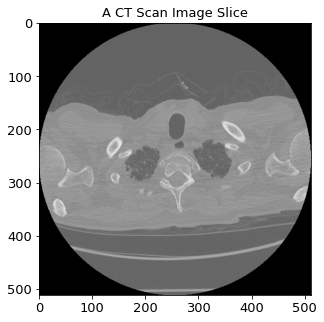

In [44]:
# Select a sample slice to work with
im = readImg('sample-dataset/ID00007637202177411956430_2.jpg', showOutput=1)
print('Image Dimensions:', im.shape)

In [45]:
# TODO: Implement histogram plotting
def imgKMeans(img, K, showOutput=0, showHistogram=0):
    '''
    Apply KMeans on an image with the number of clusters K
    Input: Image, Number of clusters K
    Output: Dictionary of cluster center labels and points, Output segmented image
    '''
    imgflat = np.reshape(img, img.shape[0] * img.shape[1]).reshape(-1, 1)
        
    kmeans = KMeans(n_clusters=K, verbose=0)
    
    kmmodel = kmeans.fit(imgflat)
    
    labels = kmmodel.labels_
    centers = kmmodel.cluster_centers_
    center_labels = dict(zip(np.arange(K), centers))
    
    output = np.array([center_labels[label] for label in labels])
    output = output.reshape(img.shape[0], img.shape[1]).astype(int)
    
#     print(len(labels), 'Labels: \n', labels)
#     print(len(centers), 'Centers: \n', centers)
#     print('Center labels and their points:', center_labels)
    
    if showOutput:

        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
        axes = axes.ravel()

        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original Image')

        axes[1].imshow(output)
        axes[1].set_title('Image after KMeans (K = ' + str(K) + ')')
    
    return center_labels, output

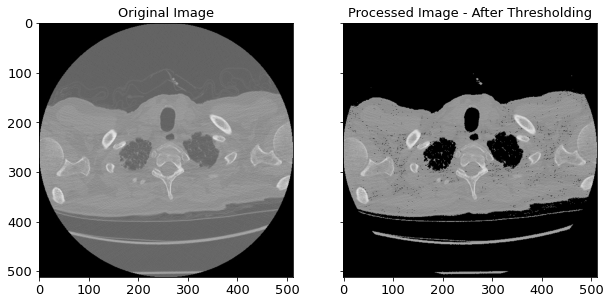

In [46]:
def preprocessImage(img, showOutput=0):
    '''
    Preprocess the image by applying truncated thresholding using KMeans
    Input: Image
    Output: Preprocessed image
    '''
    centroids, segmented_img = imgKMeans(img, 3, showOutput=0)
    
    sorted_center_values = sorted([i[0] for i in centroids.values()])
    threshold = (sorted_center_values[-1] + sorted_center_values[-2]) / 2
    
    retval, procImg = cv2.threshold(img, threshold, 255, cv2.THRESH_TOZERO) 
    
    if showOutput:
        
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
        axes = axes.ravel()

        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original Image')

        axes[1].imshow(procImg, cmap='gray')
        axes[1].set_title('Processed Image - After Thresholding')
    
    return procImg

procImg = preprocessImage(im, showOutput=1)

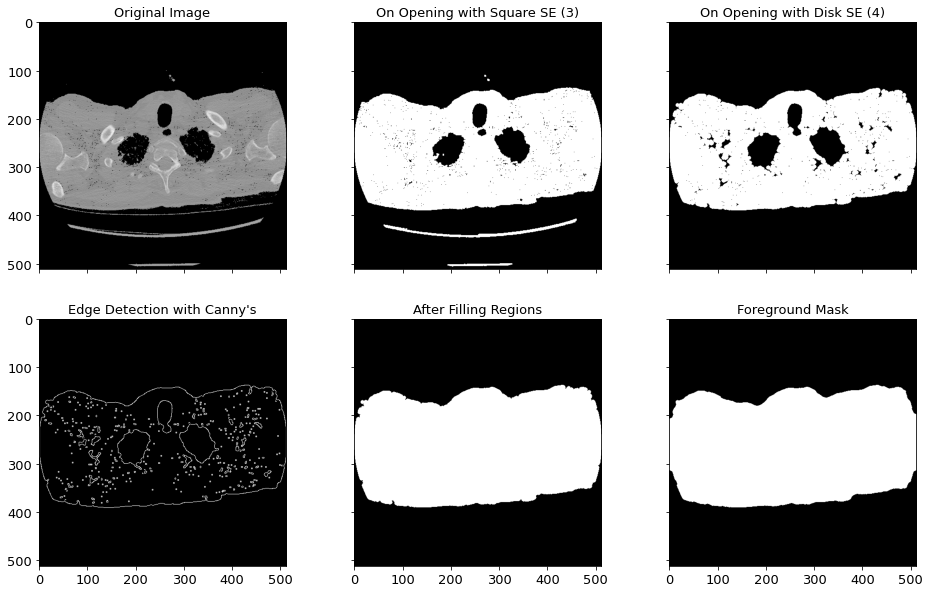

In [47]:
def cannyForegroundMask(img, showOutput=0):
    '''
    Generate a convex hull of foreground mask
    Input: Whole chest CT image in grayscale format (512x512)
    Output: Convex hull of foreground mask in binary format (512x512)
    '''
    
    centroid_clusters, segmented_img = imgKMeans(img, 2, showOutput=0)
    
    fg_threshold = sum(centroid_clusters.values())[0] / 2
    
    retval, kmeans_fg_mask = cv2.threshold(img, fg_threshold, 255, cv2.THRESH_BINARY) 
    
    fg_mask_opened = opening(kmeans_fg_mask, square(3))
    
    fg_mask_opened2 = opening(fg_mask_opened, disk(4))
    
    edges = canny(fg_mask_opened2)
    
    filled_mask = ndi.binary_fill_holes(fg_mask_opened2)
    
    fg_mask = closing(filled_mask, disk(8))
    
    if showOutput:
        fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 10))
        axes = axes.ravel()

        axes[0].set_title('Original Image')
        axes[0].imshow(img, cmap='gray')

        axes[1].set_title('On Opening with Square SE (3)')
        axes[1].imshow(fg_mask_opened, cmap='gray')

        axes[2].set_title('On Opening with Disk SE (4)')
        axes[2].imshow(fg_mask_opened2, cmap='gray')

        axes[3].set_title('Edge Detection with Canny\'s')
        axes[3].imshow(edges, cmap='gray')

        axes[4].set_title('After Filling Regions')
        axes[4].imshow(filled_mask, cmap='gray')

        axes[5].set_title('Foreground Mask')
        axes[5].imshow(fg_mask, cmap='gray')

    return fg_mask, fg_threshold

fg_mask, fg_threshold = cannyForegroundMask(procImg, showOutput=1)

In [76]:
def chullLungMask(img, ch_fg_mask, fg_threshold, showOutput=0):
    '''
    Generate a convex hull of lung mask
    Input: Whole chest CT image in grayscale format (512x512),
           Convex hull of foreground mask in binary format (512x512)
    Output: Convex hull of lung mask in binary format (512x512),
            Intermediate heart mask in binary format (512x512)
    '''
    
    enhanced = img.copy()
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            if ch_fg_mask[i][j] == 0:
                enhanced[i][j] = 255
         
    retval, initial_lung_mask = cv2.threshold(enhanced, fg_threshold, 255, cv2.THRESH_BINARY_INV) 
    
    lung_mask_op1 = opening(initial_lung_mask, square(2))
    lung_mask_op1cl1 = closing(lung_mask_op1, disk(8))    
    lung_mask_op2cl1 = opening(lung_mask_op1cl1, square(8))
    lung_mask_op3cl1 = opening(lung_mask_op2cl1, disk(8))

    label_img = label(lung_mask_op3cl1)
    lung_regions = regionprops(label_img)

    for i in lung_regions:
    #     print(i.orientation)
    #     print(i.area)
    #     print(i.label)
        if i.area < 1500:
            trachea_mask = np.where(label_img==i.label, np.uint8(255), np.uint8(0))
#             plt.imshow(mask, cmap='gray')
    
    lung_mask = lung_mask_op3cl1 - trachea_mask
    
    ch_lung_mask = convex_hull_image(lung_mask)
    
    initial_int_heart_mask = ch_lung_mask * np.invert(lung_mask)
    int_heart_mask_op1 = opening(initial_int_heart_mask, square(3))
    int_heart_mask = opening(int_heart_mask_op1, disk(3))
    
    if showOutput:
        
        fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(20, 20))
        axes = axes.ravel()

        axes[0].set_title('Original Image')
        axes[0].imshow(img, cmap='gray')

        axes[1].set_title('Enhanced Image')
        axes[1].imshow(enhanced, cmap='gray')

        axes[2].set_title('Initial Lung Mask')
        axes[2].imshow(initial_lung_mask, cmap='gray')

        axes[3].set_title('On Opening with Square SE (2)')
        axes[3].imshow(lung_mask_op1, cmap='gray')

        axes[4].set_title('On Closing with Disk SE (8)')
        axes[4].imshow(lung_mask_op1cl1, cmap='gray')

        axes[5].set_title('On Opening with Square SE (8)')
        axes[5].imshow(lung_mask_op2cl1, cmap='gray')

        axes[6].set_title('On Opening with Disk SE (8)')
        axes[6].imshow(lung_mask_op3cl1, cmap='gray')

        axes[7].set_title('On Closing with Disk SE (16)')
        axes[7].imshow(lung_mask, cmap='gray')

        axes[8].set_title('Convex Hull of Lung Mask')
        axes[8].imshow(ch_lung_mask, cmap='gray')

        axes[9].set_title('Initial Intermediate heart mask')
        axes[9].imshow(initial_int_heart_mask, cmap='gray')

        axes[10].set_title('On Opening with Square SE (3)')
        axes[10].imshow(int_heart_mask_op1, cmap='gray')

        axes[11].set_title('Intermediate heart mask')
        axes[11].imshow(int_heart_mask, cmap='gray')
    
    return lung_mask, ch_lung_mask, int_heart_mask

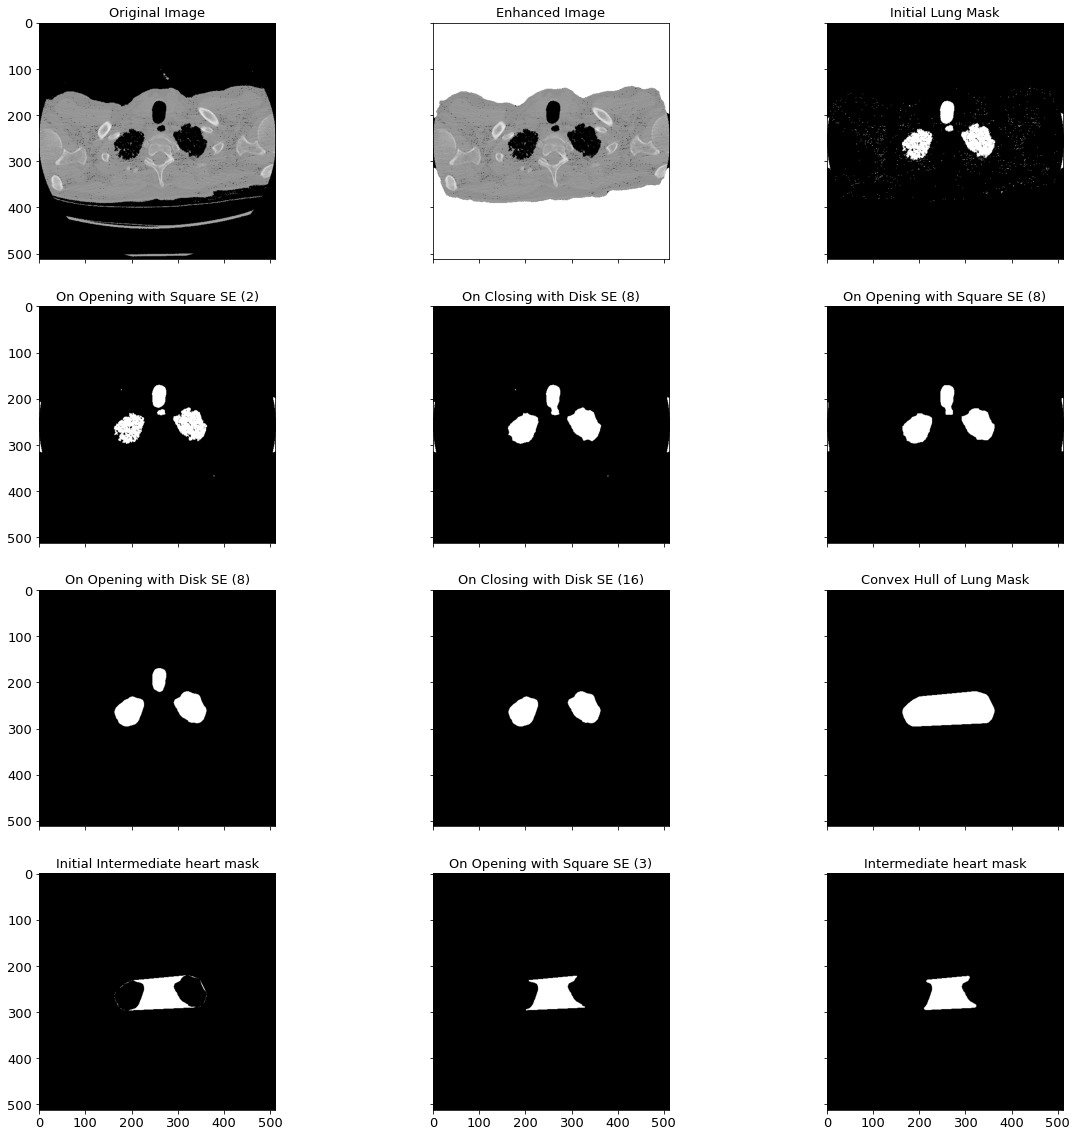

In [77]:
lung_mask, ch_lung_mask, int_heart_mask = chullLungMask(procImg, fg_mask, fg_threshold, showOutput=1)

In [78]:
def chullSpineMask(img, int_heart_mask, showOutput=0):
    
    if not int_heart_mask.any():
        return int_heart_mask, int_heart_mask
    
    int_heart_pixel = img.copy()
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if int_heart_mask[i][j] == 0:
                int_heart_pixel[i][j] = 0
                
    centroids, segmented_heart_img = imgKMeans(int_heart_pixel, 3, showOutput=0)
    
    spine_threshold = (max(centroids.values()))[0]

    retval, initial_spine_mask = cv2.threshold(int_heart_pixel, spine_threshold, 255, cv2.THRESH_BINARY) 
    
    spine_mask_cl1 = closing(initial_spine_mask, disk(20))
    spine_mask = opening(spine_mask_cl1, square(4))    
    
    label_img = label(spine_mask)
    spine_regions = regionprops(label_img)

    # Center point of the spine
    y0, x0 = spine_regions[0].centroid
    
    orientation = spine_regions[0].orientation

    # Top-most point of the spine
    x2 = x0 - math.sin(orientation) * 0.6 * spine_regions[0].axis_major_length
    y2 = y0 - math.cos(orientation) * 0.6 * spine_regions[0].axis_major_length

    chull_spine_mask = spine_mask.copy()

    # Vertical axis
    for i in range(math.ceil(y2), img.shape[1]):

        if i > math.ceil(y0):
            # Horizontal axis
            for j in range(img.shape[0]):
                chull_spine_mask[i][j] = 255
        else:
            # Horizontal axis
            for j in range(math.ceil(x0)):
                chull_spine_mask[i][j] = 255

    heart_mask = int_heart_mask * np.invert(chull_spine_mask)
    
    if showOutput:
        
        fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
        axes = axes.ravel()

        axes[0].set_title('Intermediate Heart Mask')
        axes[0].imshow(int_heart_mask, cmap='gray')

        axes[1].set_title('Intermediate Heart Segment')
        axes[1].imshow(int_heart_pixel, cmap='gray')
        
        axes[2].set_title('Intermediate Heart Segment on K-Means (K = 3)')
        axes[2].imshow(segmented_heart_img)

        axes[3].set_title('Spine Mask')
        axes[3].imshow(initial_spine_mask, cmap='gray')
        
        axes[4].set_title('On Closing with Disk SE (20)')
        axes[4].imshow(spine_mask_cl1, cmap='gray')
        
        axes[5].set_title('On Opening with Square SE (4)')
        axes[5].imshow(spine_mask, cmap='gray')
        
        axes[6].set_title('Centroid and uppermost point')
        axes[6].imshow(spine_mask, cmap='gray')
        axes[6].plot((x0, x2), (y0, y2), '-r', linewidth=1.5)
        axes[6].plot(x0, y0, '.g', markersize=5)
        axes[6].plot(x2, y2, '.b', markersize=5)
        
        axes[7].set_title('Convex Hull of Spine Mask')
        axes[7].imshow(chull_spine_mask, cmap='gray')
        
        axes[8].set_title('Heart Mask')
        axes[8].imshow(heart_mask, cmap='gray')
        
    return spine_mask, heart_mask

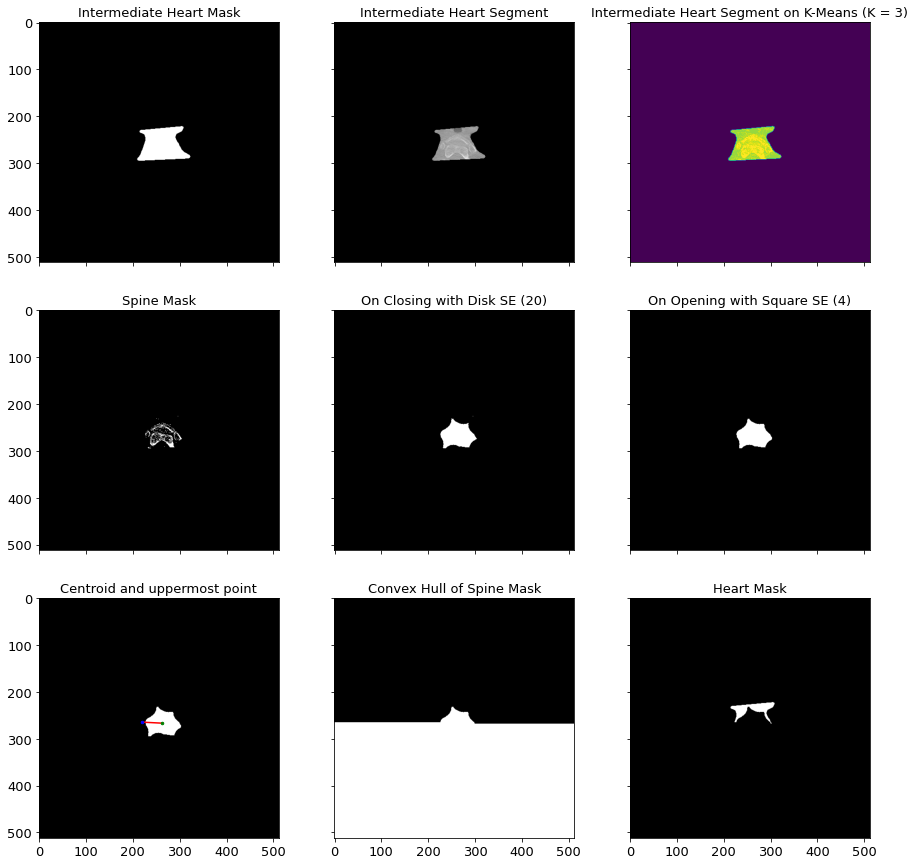

In [79]:
spine_mask, heart_mask = chullSpineMask(im, int_heart_mask, showOutput=1)

Text(0.5, 1.0, 'Heart Mask')

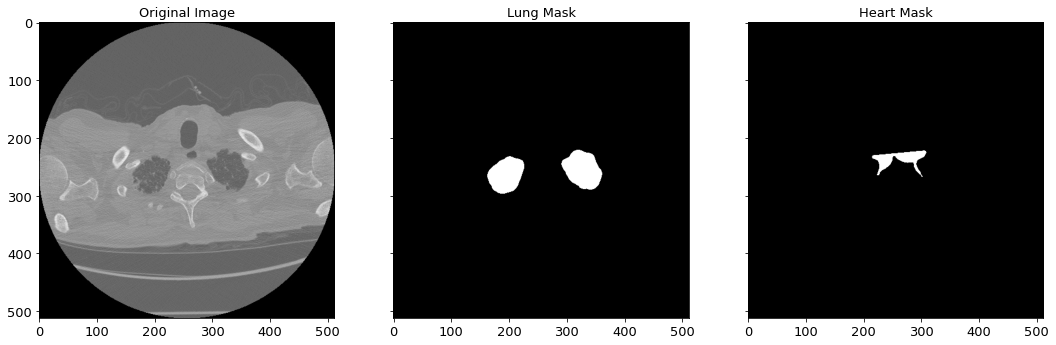

In [80]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 6))
axes = axes.ravel()
axes[0].imshow(im, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(lung_mask, cmap='gray')
axes[1].set_title('Lung Mask')
axes[2].imshow(heart_mask, cmap='gray')
axes[2].set_title('Heart Mask')

In [81]:
def segmentHeart(img, heart_mask, showOutput=0):

    seg_heart = cv2.bitwise_and(img, img, mask=heart_mask)
    
    if showOutput:
        plt.figure(figsize=(5, 5))
        plt.title('Segmented Heart')
        plt.imshow(seg_heart, cmap='gray')
    return seg_heart
    
def segmentLungs(img, lung_mask, showOutput=0): 
    
    seg_lungs = cv2.bitwise_and(img, img, mask=lung_mask)
    
    if showOutput:
        plt.figure(figsize=(5, 5))
        plt.title('Segmented Lungs')
        plt.imshow(seg_lungs, cmap='gray')
    return seg_lungs

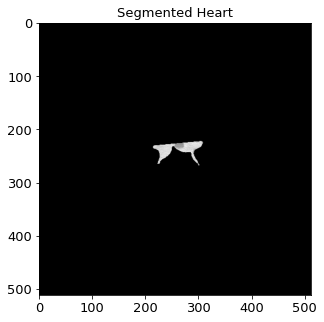

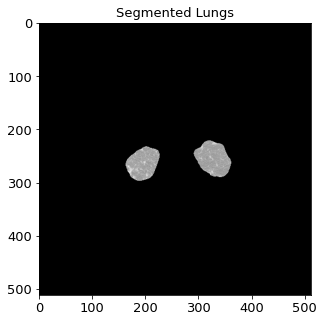

In [82]:
segmented_heart = segmentHeart(im, heart_mask, showOutput=1)
segmented_lungs = segmentLungs(im, lung_mask, showOutput=1)

In [83]:
def applyMaskColor(mask, mask_color):
    
    masked = np.concatenate(([mask[ ... , np.newaxis] * color for color in mask_color]), axis=2)
    
    # Matplotlib expects color intensities to range from 0 to 1 if a float
    maxValue = np.amax(masked)
    minValue = np.amin(masked)

    # Therefore, scale the color image accordingly
    if maxValue - minValue == 0:
        return masked
    else:
        masked = masked / (maxValue - minValue)
    
    return masked

def getColoredMasks(img, heart_mask, lung_mask, showOutput=0):
    heart_mask_color = np.array([256, 0, 0])
    lung_mask_color = np.array([0, 256, 0])

    heart_colored = applyMaskColor(heart_mask, heart_mask_color)
    lung_colored = applyMaskColor(lung_mask, lung_mask_color)
    colored_masks = heart_colored + lung_colored

    if showOutput:
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
        ax = axes.ravel()
        
        ax[0].set_title("Original Image")
        ax[0].imshow(img, cmap='gray')
        ax[1].set_title("Heart Mask")
        ax[1].imshow(heart_colored)
        ax[2].set_title("Lung Mask")
        ax[2].imshow(lung_colored)
        ax[3].set_title("Masks")
        ax[3].imshow(colored_masks)
    
    return heart_colored, lung_colored, colored_masks

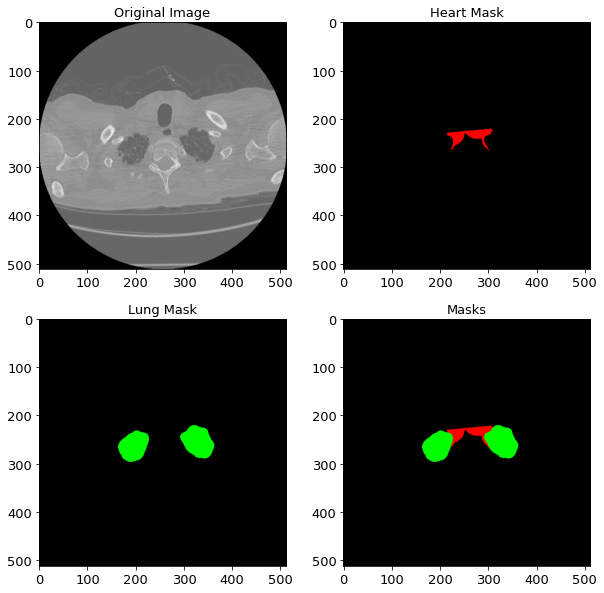

In [84]:
heart_colored, lung_colored, colored_masks = getColoredMasks(im, heart_mask, lung_mask, showOutput=1)